# CycleGAN implementation

In [16]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.model_summary import ModelSummary
from pytorch_lightning.utilities.model_summary import summarize
import matplotlib.pyplot as plt

In [ ]:
path = "/your/path/to/directory"

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Parameters
        ----------
        image_dir : str
            The directory path of all images.
        transform : callable, optional
            Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        """
        Returns the size of the dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Get the image at the given index.

        Parameters
        ----------
        idx : int
            Index of the image in the dataset.

        Returns
        -------
        image : PIL.Image
            The image at the given index.
        """
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        """
        Parameters
        ----------
        channels : int
            The number of channels in the input data.
        """
        
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        Forward pass of the ResidualBlock.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output tensor.
        """
        residual = x
        out = self.relu(self.instance_norm(self.conv1(x)))
        out = self.instance_norm(self.conv2(out))
        out += residual
        return self.relu(out)

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        """
        Parameters
        ----------
        num_residual_blocks : int, optional
            The number of residual blocks in the generator. Defaults to 9.
        """
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, 3, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        """
        Forward pass of the generator.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output tensor.
        """
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """
            Build a discriminator block.

            Parameters
            ----------
            in_filters : int
                The number of input filters.
            out_filters : int
                The number of output filters.
            normalize : bool, optional
                Whether to normalize the output. Defaults to True.

            Returns
            -------
            list
                A list of layers that can be passed to the Sequential module.
            """
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(3, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

class CycleGAN(pl.LightningModule):
    def __init__(self, lr=0.0002, b1=0.5, b2=0.999, lambda_cycle=10.0, lambda_identity=0.5):
        """
        Initialize the CycleGAN model with hyperparameters and components.

        Parameters
        ----------
        lr : float, optional
            Learning rate for the optimizers. Defaults to 0.0002.
        b1 : float, optional
            Beta1 parameter for the Adam optimizer. Defaults to 0.5.
        b2 : float, optional
            Beta2 parameter for the Adam optimizer. Defaults to 0.999.
        lambda_cycle : float, optional
            Weight for the cycle consistency loss. Defaults to 10.0.
        lambda_identity : float, optional
            Weight for the identity loss. Defaults to 0.5.
        """

        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.G_X2Y = Generator()
        self.G_Y2X = Generator()
        self.D_X = Discriminator()
        self.D_Y = Discriminator()

        self.criterion_GAN = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()

    def forward(self, x):
        return self.G_X2Y(x)

    def training_step(self, batch, batch_idx):
        """
        Training step for the CycleGAN model.

        Parameters
        ----------
        batch : tuple of torch.Tensor
            A tuple of two tensors, X and Y, containing the input data for the two domains.
        batch_idx : int
            The index of the current batch.

        Returns
        -------
        None
        """
        pass
        X, Y = batch
        g_opt, d_opt = self.optimizers()

        # Train Generators
        g_opt.zero_grad()

        # Identity loss
        loss_id_X = self.criterion_identity(self.G_Y2X(X), X)
        loss_id_Y = self.criterion_identity(self.G_X2Y(Y), Y)
        loss_identity = (loss_id_X + loss_id_Y) / 2

        # GAN loss
        fake_Y = self.G_X2Y(X)
        loss_GAN_X2Y = self.criterion_GAN(self.D_Y(fake_Y), torch.ones_like(self.D_Y(fake_Y)))
        fake_X = self.G_Y2X(Y)
        loss_GAN_Y2X = self.criterion_GAN(self.D_X(fake_X), torch.ones_like(self.D_X(fake_X)))
        loss_GAN = (loss_GAN_X2Y + loss_GAN_Y2X) / 2

        # Cycle loss
        recov_X = self.G_Y2X(fake_Y)
        loss_cycle_X = self.criterion_cycle(recov_X, X)
        recov_Y = self.G_X2Y(fake_X)
        loss_cycle_Y = self.criterion_cycle(recov_Y, Y)
        loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

        # Total generator loss
        loss_G = loss_GAN + self.hparams.lambda_cycle * loss_cycle + self.hparams.lambda_identity * loss_identity
        self.manual_backward(loss_G)
        g_opt.step()

        # Train Discriminators
        d_opt.zero_grad()

        # Real loss
        loss_real_X = self.criterion_GAN(self.D_X(X), torch.ones_like(self.D_X(X)))
        loss_real_Y = self.criterion_GAN(self.D_Y(Y), torch.ones_like(self.D_Y(Y)))

        # Fake loss
        loss_fake_X = self.criterion_GAN(self.D_X(fake_X.detach()), torch.zeros_like(self.D_X(fake_X)))
        loss_fake_Y = self.criterion_GAN(self.D_Y(fake_Y.detach()), torch.zeros_like(self.D_Y(fake_Y)))

        # Total discriminator loss
        loss_D_X = (loss_real_X + loss_fake_X) / 2
        loss_D_Y = (loss_real_Y + loss_fake_Y) / 2
        loss_D = (loss_D_X + loss_D_Y) / 2
        self.manual_backward(loss_D)
        d_opt.step()

        # Log losses
        self.log_dict({
            'loss_G': loss_G,
            'loss_D': loss_D,
            'loss_cycle': loss_cycle,
            'loss_identity': loss_identity
        }, prog_bar=True)

    def configure_optimizers(self):
        """
        Configure the optimizers for the CycleGAN model.

        Returns
        -------
        A list of two optimizers, and an empty list.
        """

        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(list(self.G_X2Y.parameters()) + list(self.G_Y2X.parameters()), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(list(self.D_X.parameters()) + list(self.D_Y.parameters()), lr=lr, betas=(b1, b2))

        return [opt_g, opt_d], []

# Data preparation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


clear_images_dir = path+"/Consolidated_Clear_Images"
hazy_images_dir = path+"/Consolidated_Hazy_Images"
clear_dataset = ImageDataset(clear_images_dir, transform=transform)
hazy_dataset = ImageDataset(hazy_images_dir, transform=transform)



In [ ]:
# Training
# Create a CycleGAN model
model = CycleGAN()

# Create a ModelCheckpoint callback to save the model with the lowest loss_G
# The model will be saved in the directory path+'/cyclegan_checkpoint'
# The monitor parameter is set to 'loss_G' to monitor the loss_G value during training
# The save_top_k parameter is set to -1 to save all models
checkpoint_callback = ModelCheckpoint(dirpath=path+'/cyclegan_checkpoint', save_top_k=-1, monitor='loss_G')

# Create a Trainer with the max_epochs set to 5
# The accelerator parameter is set to "gpu" to use a GPU for training
# The devices parameter is set to 1 to use only one GPU
# The callbacks parameter is set to [checkpoint_callback] to use the ModelCheckpoint callback
trainer = pl.Trainer(max_epochs=5, accelerator="gpu", devices=1, callbacks=[checkpoint_callback])

# Print the model summary with a max_depth of 1
print(summarize(model, max_depth=1))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


  | Name               | Type          | Params | Mode 
-------------------------------------------------------------
0 | G_X2Y              | Generator     | 11.4 M | train
1 | G_Y2X              | Generator     | 11.4 M | train
2 | D_X                | Discriminator | 2.8 M  | train
3 | D_Y                | Discriminator | 2.8 M  | train
4 | criterion_GAN      | MSELoss       | 0      | train
5 | criterion_cycle    | L1Loss        | 0      | train
6 | criterion_identity | L1Loss        | 0      | train
-------------------------------------------------------------
28.3 M    Trainable params
0         Non-trainable params
28.3 M    Total params
113.143   Total estimated model params size (MB)
165       Modules in train mode
0         Modules in eval mode


In [ ]:
# Train the model with the clear and hazy datasets
# The train_dataloaders parameter is a list of two DataLoader objects, one for each dataset
# The batch_size parameter is set to 30 to use a batch size of 30 for training
# The shuffle parameter is set to True to shuffle the data in the dataloaders
# The num_workers parameter is set to 4 to use 4 workers for loading the data
trainer.fit(model,
trainer.fit(model,
            train_dataloaders=[
                DataLoader(clear_dataset, batch_size=30, shuffle=True, num_workers=4),
                DataLoader(hazy_dataset, batch_size=30, shuffle=True, num_workers=4)
            ])

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# Generate clear images from test hazy images
# The model is set to eval mode
# The test dataset is created from the test directory
# The test loader is created with a batch size of 1 and no shuffling
test_dir = path+"/Consolidated_Test_Clips"
output_dir = path+"/cyclegan"

model.eval()
test_dataset = ImageDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Loop through the test loader and generate clear images
with torch.no_grad():
    for i, hazy_image in enumerate(test_loader):
        # Get the clear image from the model
        clear_image = model(hazy_image)
        
        # Convert the clear image to a PIL image
        save_image = transforms.ToPILImage()(clear_image[0] * 0.5 + 0.5)
        
        # Save the clear image with a filename like 'clear_image_0.png'
        save_image.save(os.path.join(output_dir, f'clear_image_{i}.png'))

# Generating images

In [ ]:
# Define directories for test images and output
test_dir = path+"/Test"  # Directory containing hazy test images
output_dir = path+"/cyclegan_test"  # Directory to save generated clear images

# Set model to evaluation mode
model.eval()

# Create test dataset and dataloader
test_dataset = ImageDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Disable gradient computation for inference
with torch.no_grad():
    # Iterate over the test loader
    for i, hazy_image in enumerate(test_loader):
        # Generate a clear image using the model
        clear_image = model(hazy_image)

        # Extract the original filename without extension
        original_filename = os.path.splitext(test_dataset.image_files[i])[0]

        # Construct the new filename with 'clear_' prefix
        new_filename = f"clear_{original_filename}.png"

        # Convert the clear image tensor to a PIL image and save it
        save_image = transforms.ToPILImage()(clear_image[0] * 0.5 + 0.5)
        save_image.save(os.path.join(output_dir, new_filename))

Enter the path to the hazy image: /content/drive/MyDrive/gen AI Project/Consolidated_Hazy_Images/TLH_10_TLH_10_004.png


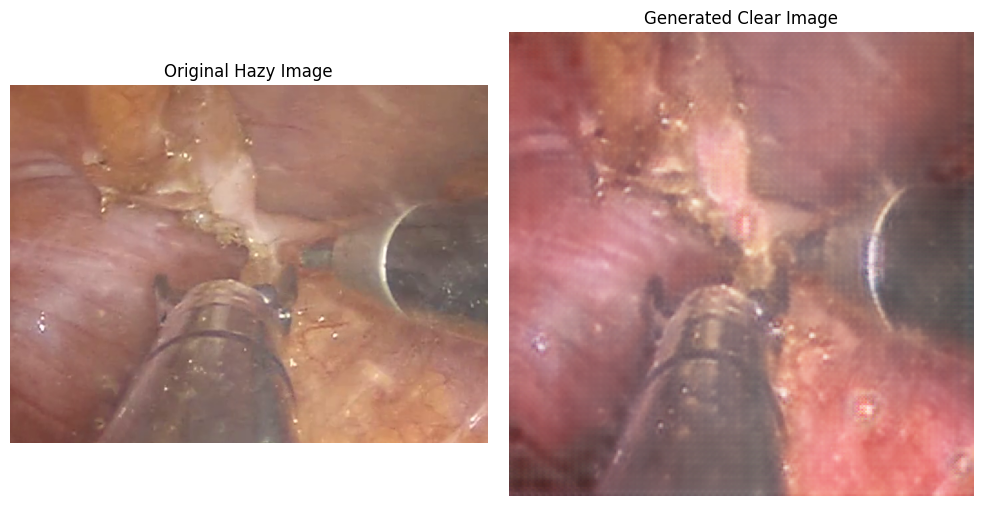

In [ ]:
# Load the trained model from checkpoint
# The trained model is loaded from the checkpoint saved during training
model = CycleGAN.load_from_checkpoint(path+"/cyclegan_checkpoint/epoch=4-step=30000.ckpt", map_location="cpu")
model.eval()

# Ask user for input image path
# The user is prompted to enter the path to a hazy image
input_path = input("Enter the path to the hazy image: ")
assert os.path.isfile(input_path), "Invalid file path!"

# Load and preprocess the image
# The image is loaded and preprocessed using the same transform as training
image = Image.open(input_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Generate the clear image
# The clear image is generated by passing the preprocessed image through the model
with torch.no_grad():
    clear_tensor = model(image_tensor)

# Post-process and convert tensor to image
# The generated image tensor is de-normalized and converted to a PIL image
clear_image = clear_tensor.squeeze(0) * 0.5 + 0.5  # De-normalize
clear_image = transforms.ToPILImage()(clear_image.clamp(0, 1))

# Display the original and generated images side by side
# The original and generated images are displayed side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Original Hazy Image")
axes[0].axis("off")

axes[1].imshow(clear_image)
axes[1].set_title("Generated Clear Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()


# Metrics

In [ ]:
import numpy as np
from scipy import signal

def compute_fade(image):
    # Convert image to grayscale if it's not already
    """
    Compute the FADE score of an image.

    The FADE score is a metric that measures the difference between the original
    image and the dehazed image. The score is computed as the mean of the NSS
    features of the absolute difference between the original image and the
    dehazed image.

    Parameters
    ----------
    image : array_like
        The image to compute the FADE score for.

    Returns
    -------
    fade_score : float
        The FADE score of the image.

    """

    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # Compute local contrast
    kernel = np.ones((3, 3)) / 9
    local_mean = signal.convolve2d(image, kernel, mode='same')
    local_contrast = np.abs(image - local_mean)

    # Compute NSS features
    nss_features = compute_nss_features(local_contrast)

    # Compute FADE score (this is a simplified version)
    fade_score = np.mean(nss_features)

    return fade_score

def compute_nss_features(local_contrast):

    """
    Compute NSS features from local contrast.

    This function serves as a placeholder for computing Natural Scene Statistics (NSS)
    features from the local contrast of an image. NSS features are statistical measures
    of the image that are useful in image quality assessment and other image processing tasks.

    Parameters
    ----------
    local_contrast : array_like
        The local contrast of the image, typically computed as the absolute difference
        between the image and its local mean.

    Returns
    -------
    array_like
        The NSS features derived from the local contrast. In this placeholder, it simply
        returns the local contrast as the NSS features.
    """

    return local_contrast

In [ ]:
import numpy as np
from scipy import ndimage

def compute_jnbm(image):
    # Convert image to grayscale if it's not already
    """
    Compute the Just Noticeable Blur Metric (JNBM) of an image.

    The JNBM is a measure of the bluriness of an image. It is computed as the mean of the
    blur ratio at each edge pixel, where the blur ratio is the ratio of the edge strength
    of the image at that pixel to the Just Noticeable Blur (JNB) at that pixel.

    Parameters
    ----------
    image : array_like
        The image to compute the JNBM score for.

    Returns
    -------
    float
        The JNBM score of the image.

    """
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # Compute edge map
    edge_map = compute_edge_map(image)

    # Compute local contrast
    local_contrast = compute_local_contrast(image)

    # Compute JNB at each edge pixel
    jnb = compute_jnb(local_contrast)

    # Compute blur ratio at each edge pixel
    blur_ratio = compute_blur_ratio(edge_map, jnb)

    # Compute final JNBM score
    jnbm_score = np.mean(blur_ratio)

    return jnbm_score

def compute_edge_map(image):
    # Placeholder for edge detection
    """
    Compute the edge map of an image.

    This function serves as a placeholder for edge detection algorithms. In this
    placeholder, it simply uses the Sobel operator to detect edges in the image.

    Parameters
    ----------
    image : array_like
        The image to compute the edge map for.

    Returns
    -------
    edge_map : array_like
        The edge map of the image, where the value at each pixel is the strength of
        the edge at that pixel.
    """
    return ndimage.sobel(image)

def compute_local_contrast(image):
    # Placeholder for local contrast computation
    """
    Compute the local contrast of an image.

    This function serves as a placeholder for local contrast computation algorithms.
    In this placeholder, it simply computes the absolute difference between the original
    image and a blurred version of the image, where the blur is achieved by convolving
    the image with a uniform filter of size 3.

    Parameters
    ----------
    image : array_like
        The image to compute the local contrast for.

    Returns
    -------
    local_contrast : array_like
        The local contrast of the image, where the value at each pixel is the
        difference between the original pixel value and the blurred pixel value.
    """
    return np.abs(image - ndimage.uniform_filter(image, size=3))

def compute_jnb(local_contrast):
    # Placeholder for JNB computation
    """
    Compute the Just Noticeable Blur (JNB) of an image.

    The JNB is a measure of the minimum amount of blur that can be perceived
    in an image. It is computed as a function of the local contrast of the
    image.

    Parameters
    ----------
    local_contrast : array_like
        The local contrast of the image, where the value at each pixel is the
        difference between the original pixel value and the blurred pixel value.

    Returns
    -------
    jnb : array_like
        The JNB of the image, where the value at each pixel is the minimum
        amount of blur that can be perceived at that pixel.
    """
    return 5 / (1 + np.exp(-0.5 * local_contrast))

def compute_blur_ratio(edge_map, jnb):
    # Placeholder for blur ratio computation
    # only compute ratio where both edge_map > 0 and jnb > 0
    """
    Compute the blur ratio of an image.

    The blur ratio is a measure of the bluriness of an image, computed as the ratio
    of the edge strength of the image to the Just Noticeable Blur (JNB) at each pixel.

    Parameters
    ----------
    edge_map : array_like
        The edge map of the image, where the value at each pixel is the strength of
        the edge at that pixel.
    jnb : array_like
        The Just Noticeable Blur (JNB) of the image, where the value at each pixel
        is the minimum amount of blur that can be perceived at that pixel.

    Returns
    -------
    blur_ratio : array_like
        The blur ratio of the image, where the value at each pixel is the ratio of
        the edge strength to the JNB at that pixel.
    """
    ratio = np.zeros_like(edge_map, dtype=float)
    mask  = (edge_map > 0) & (jnb > 0)
    ratio[mask] = edge_map[mask] / (jnb[mask] + 1e-8)  # add tiny eps to avoid zero‐div
    return ratio

In [ ]:
import numpy as np
from scipy import ndimage

def compute_rea(original_image, restored_image):
    # Convert images to grayscale if they're not already
    """
    Compute the Relative Edge Accuracy (REA) of an image.

    The REA is a measure of the accuracy of the edges in an image, computed as the ratio
    of the number of visible edges in the restored image to the total number of edges
    in the original image.

    Parameters
    ----------
    original_image : array_like
        The original image to compute the REA for.
    restored_image : array_like
        The restored image to compute the REA for.

    Returns
    -------
    rea_score : float
        The REA score of the image.
    """

    if len(original_image.shape) == 3:
        original_image = np.mean(original_image, axis=2)
    if len(restored_image.shape) == 3:
        restored_image = np.mean(restored_image, axis=2)

    # Compute edge maps
    original_edges = compute_edge_map(original_image)
    restored_edges = compute_edge_map(restored_image)

    # Compute visible edges ratio
    visible_edges_ratio = compute_visible_edges_ratio(original_edges, restored_edges)

    # Compute REA score
    rea_score = np.mean(visible_edges_ratio)

    return rea_score

def compute_edge_map(image):
    # Placeholder for edge detection
    """
    Compute the edge map of an image.

    This function serves as a placeholder for edge detection algorithms.
    In this placeholder, it simply computes the gradient of the image using the
    Sobel operator.

    Parameters
    ----------
    image : array_like
        The image to compute the edge map for.

    Returns
    -------
    edge_map : array_like
        The edge map of the image, where the value at each pixel is the strength of
        the edge at that pixel.
    """
    return ndimage.sobel(image)

def compute_visible_edges_ratio(original_edges, restored_edges):
    # Placeholder for visible edges ratio computation
    # compute restored/original only where original_edges > 0
    """
    Compute the ratio of visible edges between restored and original edge maps.

    This function calculates the visible edges ratio by dividing the restored
    edges by the original edges, only at positions where the original edge
    values are greater than zero. A small epsilon is added to the denominator
    to prevent division by zero.

    Parameters
    ----------
    original_edges : array_like
        The edge map of the original image, where the value at each pixel
        represents the strength of the edge.
    restored_edges : array_like
        The edge map of the restored image, where the value at each pixel
        represents the strength of the edge.

    Returns
    -------
    array_like
        The visible edges ratio, where each value represents the ratio of
        restored to original edge strength at each pixel position.
    """

    ratio = np.zeros_like(original_edges, dtype=float)
    mask  = original_edges > 0
    ratio[mask] = restored_edges[mask] / (original_edges[mask] + 1e-8)
    return ratio

In [ ]:
import os
import numpy as np
from skimage import io
import cv2
from PIL import Image

def calculate_metrics(original_path, generated_path):
    """
    Calculate average image quality metrics between original and generated images.

    This function computes three metrics: FADE, JNBM, and REA for each pair of 
    original and generated images in specified directories. It resizes images 
    to 256x256, converts them to grayscale, and calculates the metrics using 
    predefined functions. The function returns the average values of these metrics
    across all image pairs.

    Parameters
    ----------
    original_path : str
        The file path to the directory containing original images.
    generated_path : str
        The file path to the directory containing generated images, named with 
        'clear_image_{index}.png' format.

    Returns
    -------
    tuple
        A tuple containing the average FADE, JNBM, and REA values.
    """

    fade_values = []
    jnbm_values = []
    rea_values = []

    # Iterate through the images in both directories
    for i,filename in enumerate(os.listdir(original_path)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Read the original and generated images
            original_img = io.imread(os.path.join(original_path, filename))
            generated_img = io.imread(os.path.join(generated_path, f'clear_image_{i}.png'))

            # Convert NumPy array to PIL Image for resizing
            original_img_pil = Image.fromarray(original_img)
            generated_img_pil = Image.fromarray(generated_img)

            # Resize images to 256x256
            original_img_resized = original_img_pil.resize((256, 256))
            generated_img_resized = generated_img_pil.resize((256, 256))

            # Convert images back to NumPy arrays
            original_img_resized = np.array(original_img_resized)
            generated_img_resized = np.array(generated_img_resized)

            # Convert images to grayscale if they're not already
            if len(original_img_resized.shape) == 3:
                original_img_resized = cv2.cvtColor(original_img_resized, cv2.COLOR_RGB2GRAY)
            if len(generated_img_resized.shape) == 3:
                generated_img_resized = cv2.cvtColor(generated_img_resized, cv2.COLOR_RGB2GRAY)

            # Calculate metrics
            fade = compute_fade(generated_img_resized)
            jnbm = compute_jnbm(generated_img_resized)
            rea = compute_rea(original_img_resized, generated_img_resized)

            # Append values to lists
            fade_values.append(fade)
            jnbm_values.append(jnbm)
            rea_values.append(rea)

    # Calculate averages
    avg_fade = np.mean(fade_values)
    avg_jnbm = np.mean(jnbm_values)
    avg_rea = np.mean(rea_values)

    return avg_fade, avg_jnbm, avg_rea

# Paths to the original and generated image directories
original_path = path+"/Consolidated_Test_Clips"
generated_path = path+"/cyclegan"

# Calculate average metrics
avg_fade, avg_jnbm, avg_rea = calculate_metrics(original_path, generated_path)

print(f"Average FADE: {avg_fade:.4f}")
print(f"Average JNBM: {avg_jnbm:.4f}")
print(f"Average REA: {avg_rea:.4f}")


Average FADE: 2.5761
Average JNBM: 36.1544
Average REA: 7.5609
